Number of columns in the dataset: 30970
Number of duplicated rows in the dataset: 97
Number of rows where column '2' has value 1: 497
Number of rows where column '2' has value 0: 930
Number of rows where column '2' has value 1: 497
Number of rows where column '2' has value 0: 630
Number of columns removed: 30050
Number of columns remaining: 920
(1127, 919)
Goodware data shape: (630, 920)
Number of rows with label 1 in the training set: 342
Number of rows with label 0 in the training set: 459
Number of rows with label 1 in the validation set: 61
Number of rows with label 0 in the validation set: 81
Number of rows with label 1 in the unseen set: 94
Number of rows with label 0 in the unseen set: 90
X_train shape: (801, 917)
X_validate shape: (142, 917)
X_unseen shape: (184, 917)
Cross-Validation Scores (Logistic Regression): [0.85714286 0.86875    0.8875     0.8875     0.9       ]
Mean Cross-Validation Accuracy (Logistic Regression): 0.8801785714285716
Accuracy on Testing Set for Binary C

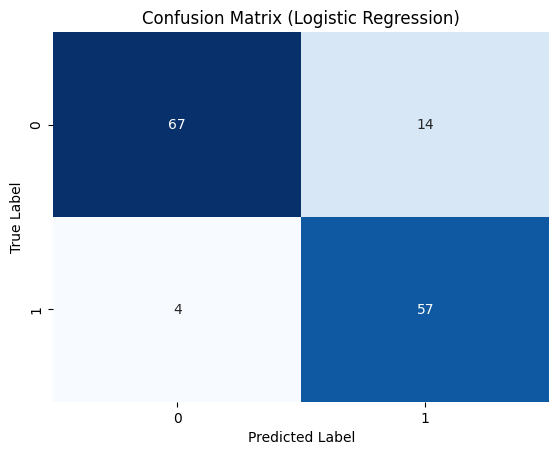

Accuracy on Unseen Set for Binary Classification (Logistic Regression): 0.8695652173913043
Classification Report on Unseen Set (Logistic Regression):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        90
           1       0.89      0.85      0.87        94

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



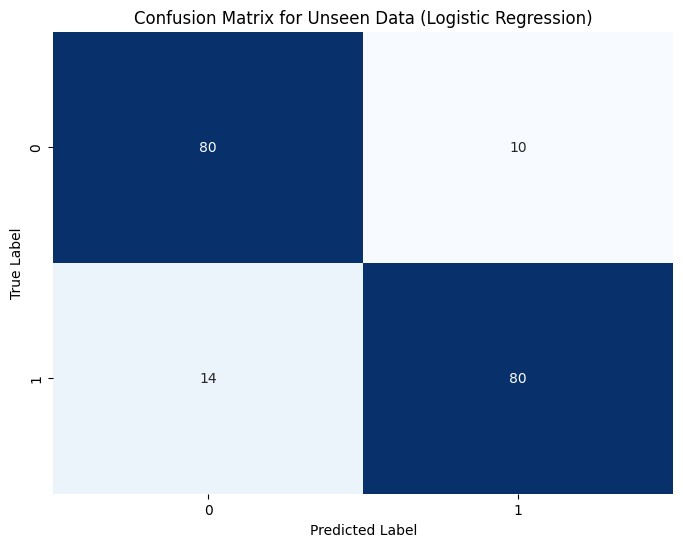

Selected Features for Binary Classification (Logistic Regression): Index(['2815', '1807', '11579', '5287', '1896', '21004', '10', '3367', '18253',
       '12244', '543', '25', '23286', '57', '2018', '67', '227', '151', '170',
       '12043', '332', '11686', '122', '14267'],
      dtype='object')


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split ,cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression




# Load your dataset
your_dataset_path = 'RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)



column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names



#give number of columns in the dataset 
num_columns = len(df.columns)
print("Number of columns in the dataset:", num_columns)
df = df.drop(columns=['1'])

num_duplicates = df.duplicated().sum()
print("Number of duplicated rows in the dataset:", num_duplicates)

df=df.drop_duplicates()

num_rows_with_1 = df[df['2'] == 1].shape[0]
print(f"Number of rows where column '2' has value 1: {num_rows_with_1}")

# Count the number of rows where column '2' has value 0
num_rows_with_0 = df[df['2'] == 0].shape[0]
print(f"Number of rows where column '2' has value 0: {num_rows_with_0}")


# Set the desired number of rows for column '2' with value 0
# delete 400  rows where column '2' has value 0 randomly without touching the rows where column '2' has value 1 
# Set the desired number of rows for column '2' with value 0
desired_rows = 300

# Get the indices of rows where column '2' has value 0
rows_with_0 = df.index[df['2'] == 0]

# Randomly select 400 indices from rows_with_0
rows_to_delete = np.random.choice(rows_with_0, size=desired_rows, replace=False)

# Delete the selected rows
df = df.drop(rows_to_delete)

num_rows_with_1 = df[df['2'] == 1].shape[0]
print(f"Number of rows where column '2' has value 1: {num_rows_with_1}")

# Count the number of rows where column '2' has value 0
num_rows_with_0 = df[df['2'] == 0].shape[0]
print(f"Number of rows where column '2' has value 0: {num_rows_with_0}")


#show number of duplicated rows in the dataset
# Remove a column if all its values are zeros (or all ones) e.g., columns where 99% of the values are 0 
# Remove columns where 99% of the values are 0  and show me how many columns were removed and how many remain 
# show me how many columns were removed and how many remain 
# Remove columns where 99% of the values are 0 and show me how many columns were removed and how many remain
removed_columns = df.columns[(df == 0).mean() >= 0.99]
# remove the columns removed_columns
df = df.drop(columns=removed_columns)


num_removed_columns = len(removed_columns)

print("Number of columns removed:", num_removed_columns)
print("Number of columns remaining:", 30970-num_removed_columns)
print(df.shape)




# Drop the first column as instructed


# Count the number of duplicated rows in the dataset


# Define the unseen and seen class IDs
unseen_classes_ids = [8, 9, 11]  # IDs of unseen ransomware classes
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]  # IDs of seen ransomware classes plus goodware
df['Label'] = df['3'].astype(int) 
df['2'] = df['2'].astype(int)  # Ensure the column is of integer type


# Separate the unseen ransomware data
unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]

# Separate the seen ransomware data
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

# Goodware samples
goodware_data = df[df['Label'] == 0]

goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)

#print goodware data shape
print("Goodware data shape:", goodware_data.shape)


# Now we split the goodware data based on the count needed for the training set
goodware_train = goodware_data.iloc[:540, :]
goodware_unseen = goodware_data.iloc[540:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])


#drop 321 random rows from the train data with label 0 to make sure the number of rows with label 1 is equal to the number of rows with label 0 
# Split the train data into actual training and validation sets
y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])


X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42  # ~20% for validation to make a total of 1257
)


# Prepare the unseen data
unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])
# Undersampling: Reduce the number of instances in the majority class (label 0) by randomly removing examples
# from the majority class until the number of instances in the majority class is equal to the number of instances in the minority class (label 1) 

y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])


#for the training set show numberof rows with label 1 and label 0
# Count the number of rows with label 1 and label 0 in the training set
num_label1 = y_train[y_train == 1].shape[0]
num_label0 = y_train[y_train == 0].shape[0]

print("Number of rows with label 1 in the training set:", num_label1)
print("Number of rows with label 0 in the training set:", num_label0)

# Count the number of rows with label 1 and label 0 in the validation set and print them 
num_label1 = y_validate[y_validate == 1].shape[0]
num_label0 = y_validate[y_validate == 0].shape[0]

print("Number of rows with label 1 in the validation set:", num_label1)
print("Number of rows with label 0 in the validation set:", num_label0)

# Count the number of rows with label 1 and label 0 in the unseen set and print them 
num_label1_unseen = y_unseen[y_unseen == 1].shape[0]
num_label0_unseen = y_unseen[y_unseen == 0].shape[0]

print("Number of rows with label 1 in the unseen set:", num_label1_unseen)
print("Number of rows with label 0 in the unseen set:", num_label0_unseen)

print("X_train shape:", X_train.shape)
#print("y_train shape:", y_train.shape)
print("X_validate shape:", X_validate.shape)
#print("y_validate shape:", y_validate.shape)
print("X_unseen shape:", X_unseen.shape)
#print("y_unseen shape:", y_unseen.shape)










# Feature selection using Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)

# Select top k features based on Mutual Information
num_features_to_select = 24  # Adjust based on experimentation
selected_features_indices = np.argsort(mi_scores)[-num_features_to_select:]
selected_features_mutual_info = X_train.columns[selected_features_indices]

X_train_mi = X_train[selected_features_mutual_info]
X_validate_mi = X_validate[selected_features_mutual_info]
X_unseen_mi = X_unseen[selected_features_mutual_info]

# Logistic Regression Classifier
logreg_model_binary = LogisticRegression(random_state=42)

# Cross-validation on training set
cv_scores_logreg = cross_val_score(logreg_model_binary, X_train_mi, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Logistic Regression):", cv_scores_logreg)
print("Mean Cross-Validation Accuracy (Logistic Regression):", np.mean(cv_scores_logreg))

# Fit the Logistic Regression model on training data
logreg_model_binary.fit(X_train_mi, y_train)

# Predict on validation set
y_pred_logreg_binary = logreg_model_binary.predict(X_validate_mi)

# Evaluate performance
accuracy_logreg_binary = accuracy_score(y_validate, y_pred_logreg_binary)
print("Accuracy on Testing Set for Binary Classification (Logistic Regression):", accuracy_logreg_binary)

# Additional evaluation metrics
print("Classification Report (Logistic Regression):")
print(classification_report(y_validate, y_pred_logreg_binary))

# Confusion Matrix (Logistic Regression)
cm_logreg = confusion_matrix(y_validate, y_pred_logreg_binary)

# Visualization using Seaborn
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Apply the trained Logistic Regression model to the unseen data
y_pred_unseen_logreg = logreg_model_binary.predict(X_unseen_mi)

# Evaluate performance on the unseen dataset
accuracy_unseen_logreg = accuracy_score(y_unseen, y_pred_unseen_logreg)
print("Accuracy on Unseen Set for Binary Classification (Logistic Regression):", accuracy_unseen_logreg)

# Additional evaluation metrics for the unseen dataset
print("Classification Report on Unseen Set (Logistic Regression):")
print(classification_report(y_unseen, y_pred_unseen_logreg))

# Confusion Matrix for Unseen Data (Logistic Regression)
cm_unseen_logreg = confusion_matrix(y_unseen, y_pred_unseen_logreg)

# Visualization using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_unseen_logreg, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Unseen Data (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Selected Features for Binary Classification (Logistic Regression):", selected_features_mutual_info)